In [1]:
import tensorflow as tf
from src.utils import *
from src.losses import *
from src.models import *
from src.dataset import *
from src.pretraining import *
from src.learning_rate_schedulers import *

In [2]:
print('Tensorflow Version: {}'.format(tf.__version__))
set_memory_growth()

Tensorflow Version: 2.0.0
Detect 1 Physical GPUs, 1 Logical GPUs.


## Data Loader

In [3]:
tfrecord_creator = TFRecordCreator(
    '../DIV2K_train_HR/',
    '../DIV2K_train_LR_bicubic/X4'
)
tfrecord_creator.make_tfrecord_file('div2d_4x_bicubic.tfrecord')

100%|██████████| 800/800 [00:05<00:00, 158.43it/s]


In [4]:
dataloader = SRTfrecordDataset(256)
dataset = dataloader.get_dataset('./div2d_4x_bicubic.tfrecord', 8, 1024)
dataset

<PrefetchDataset shapes: ((8, 64, 64, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

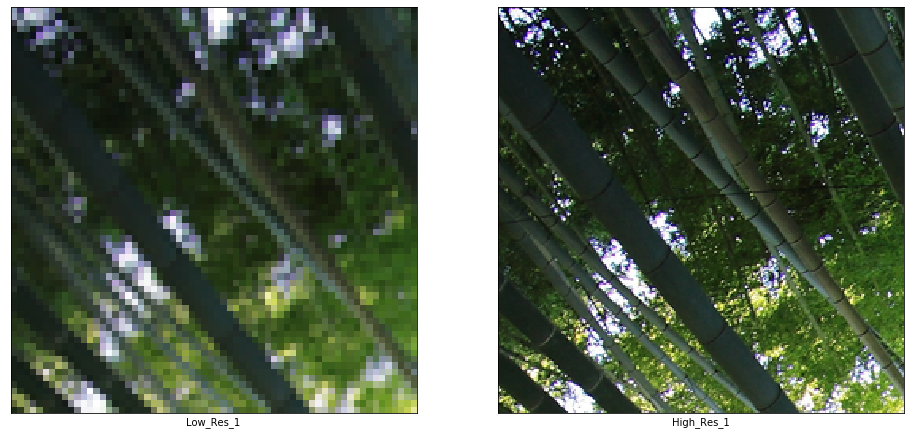

In [5]:
visualize_batch(dataset)

## Models

In [9]:
generator = Generator(64, 3)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 64, 64, 64)   1792        input_image[0][0]                
__________________________________________________________________________________________________
RRDB_trunk (Sequential)         (None, 64, 64, 64)   16546752    conv_first[0][0]                 
__________________________________________________________________________________________________
conv_trunk (Conv2D)             (None, 64, 64, 64)   36928       RRDB_trunk[0][0]                 
__________________________________________________________________________________________

In [10]:
discriminator = Discriminator(256, 3)
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv0_0 (Conv2D)             (None, 256, 256, 64)      1792      
_________________________________________________________________
conv0_1 (Conv2D)             (None, 128, 128, 64)      65536     
_________________________________________________________________
bn0_1 (BatchNormalization)   (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_706 (LeakyReLU)  (None, 128, 128, 64)      0         
_________________________________________________________________
conv1_0 (Conv2D)             (None, 128, 128, 128)     73728     
_________________________________________________________________
bn1_0 (BatchNormalization)   (None, 128, 128, 128)   

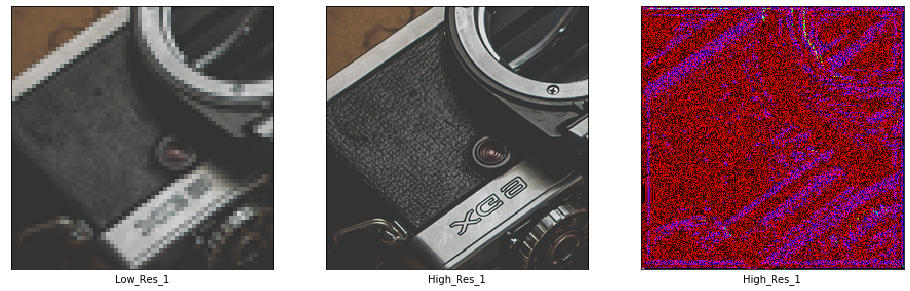

In [11]:
visualize_batch(dataset, model=generator)

## Pre-Training

In [9]:
learning_rate = MultiStepLR(float(2e-4), [200000, 400000, 600000, 800000], 0.5)
gen_optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9, beta_2=0.99
)

In [10]:
pixel_loss = PixelLoss()

In [11]:
checkpoint, checkpoint_manager, generator, optimizer = pretrain(
    dataset, generator, gen_optimizer, pixel_loss
)

0it [00:00, ?it/s]

Training from scratch....


100it [01:26,  1.16it/s]


Pre-trained Generator saved at ./models/pretrain/ckpt-1


## Training

In [12]:
gen_lr = MultiStepLR(float(1e-4), [50000, 100000, 200000, 300000], 0.5)
dis_lr = MultiStepLR(float(1e-4), [50000, 100000, 200000, 300000], 0.5)

In [13]:
optimizer_G = tf.keras.optimizers.Adam(
    learning_rate=gen_lr,
    beta_1=0.9, beta_2=0.99
)
optimizer_D = tf.keras.optimizers.Adam(
    learning_rate=dis_lr,
    beta_1=0.9, beta_2=0.99
)

In [14]:
pixel_loss_fn = PixelLoss()
fea_loss_fn = ContentLoss()
gen_loss_fn = GeneratorLoss()
dis_loss_fn = DiscriminatorLoss()

80142336/80134624 [==============================] - 1s 0us/step


In [15]:
def get_checkpoint_train(models, optimizers, checkpoint_dir='./checkpoints/'):
    checkpoint = tf.train.Checkpoint(
        step=tf.Variable(0, name='step'),
        gen_model = models[0], dis_model = models[1],
        gen_optimizer=optimizers[0], dis_optimizer=optimizers[1]
    )
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint=checkpoint,
        directory=checkpoint_dir,
        max_to_keep=3
    )
    if checkpoint_manager.latest_checkpoint:
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
        print(
            'Loaded ckpt from {} at step {}.'.format(
                checkpoint_manager.latest_checkpoint,
                checkpoint.step.numpy()
            )
        )
    else:
        print("Training from scratch....")
    return checkpoint, checkpoint_manager

In [ ]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape(persistent=True) as tape:
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)
        losses_G = {}
        losses_D = {}
        losses_G['regular'] = tf.reduce_sum(generator.losses)
        losses_D['regular'] = tf.reduce_sum(discriminator.losses)
        losses_G['pixel'] = float(1e-2) * pixel_loss_fn(hr, sr)
        losses_G['feature'] = 1.0 * fea_loss_fn(hr, sr)
        losses_G['gan'] = float(5e-3) * gen_loss_fn(hr_output, sr_output)
        losses_D['gan'] = dis_loss_fn(hr_output, sr_output)
        total_loss_G = tf.add_n([l for l in losses_G.values()])
        total_loss_D = tf.add_n([l for l in losses_D.values()])

    grads_G = tape.gradient(
        total_loss_G,
        generator.trainable_variables
    )
    grads_D = tape.gradient(
        total_loss_D,
        discriminator.trainable_variables
    )
    optimizer_G.apply_gradients(
        zip(
            grads_G,
            generator.trainable_variables
        )
    )
    optimizer_D.apply_gradients(
        zip(
            grads_D,
            discriminator.trainable_variables
        )
    )

    return total_loss_G, total_loss_D, losses_G, losses_D